# <center> Synthetic Minority Over-sampling TEchnique (SMOTE) </center>

Synthetic Minority Over-sampling TEchnique, or SMOTE for short, is a preprocessing technique used to address a class imbalance in a dataset.

At a high level, the SMOTE algorithm can be described as follows:

- Take difference between a sample and its nearest neighbour

- Multiply the difference by a random number between 0 and 1

- Add this difference to the sample to generate a new synthetic example in feature space

- Continue on with next nearest neighbour up to user-defined number

In the following examples the implementation will be used provided by the **imbalanced_learn Python Library**, which can be installed via pip as follow:

In [1]:
# pip install imbalanced-learn

## <center> Example of SMOTE for Balancing Data </center>
### <center> Using a synthetic binary classification dataset with 10,000 samples and 1:100 class distribution </center>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.neighbors import NearestNeighbors
from sklearn.datasets import make_classification
from collections import Counter
from numpy import where

Counter({0: 9900, 1: 100})


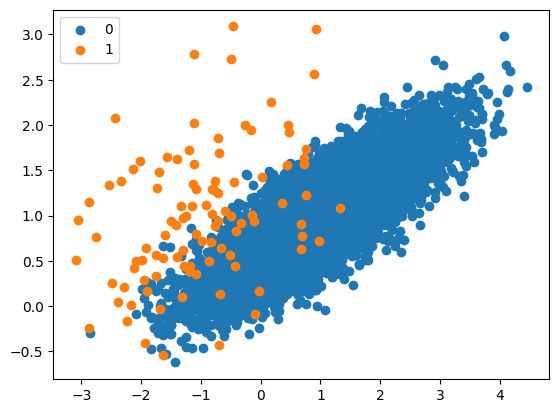

In [3]:
## Generate and plot a synthetic imbalanced classification dataset

# Creating dataset
X, y = make_classification(n_samples = 10_000, n_features = 2, n_redundant = 0, 
                           n_clusters_per_class = 1, weights = [0.99], flip_y = 0, random_state = 1)

# Summarize class distribution
counter = Counter(y)
print(counter)

# Visualization of examples by class label
for label, _ in counter.items():
    row_ix = where(y == label)[0]
    plt.scatter(X[row_ix, 0], X[row_ix, 1], label = str(label))
plt.legend()
plt.show()

Counter({0: 9900, 1: 9900})


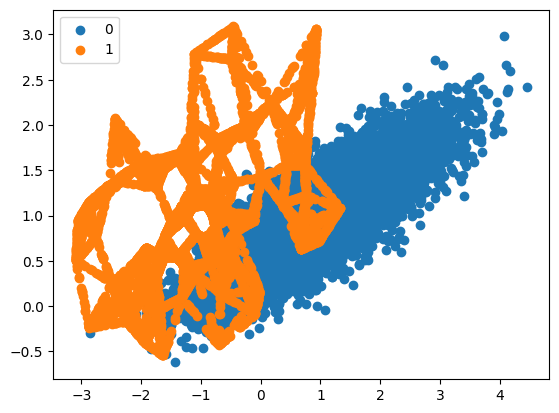

In [4]:
# SMOTE with default parameters

from imblearn.over_sampling import SMOTE

oversample = SMOTE()
X_os, y_os = oversample.fit_resample(X, y)

# Summarize class distribution
counter = Counter(y_os)
print(counter)

# Visualization of examples by class label
for label, _ in counter.items():
    row_ix = where(y_os == label)[0]
    plt.scatter(X_os[row_ix, 0], X_os[row_ix, 1], label = str(label))
plt.legend()
plt.show()

The original paper on SMOTE suggested combining SMOTE with random undersampling of the majority class.

The imbalanced-learn library supports random undersampling via the **RandomUnderSampler class**.

We can update the example to first **oversample** the minority class to have **10 percent** the number of examples of the majority class (e.g. about 1,000), then use random **undersampling** to reduce the number of examples in the majority class to have **50 percent** more than the minority class (e.g. about 2,000).

In [5]:
from imblearn.under_sampling import RandomUnderSampler

over = SMOTE(sampling_strategy = 0.1)
under = RandomUnderSampler(sampling_strategy = 0.5)

We can then chain these two transforms together into a Pipeline.

The Pipeline can then be applied to a dataset, performing each transformation in turn and returning a final dataset with the accumulation of the transform applied to it, in this case oversampling followed by undersampling.

Counter({0: 1980, 1: 990})


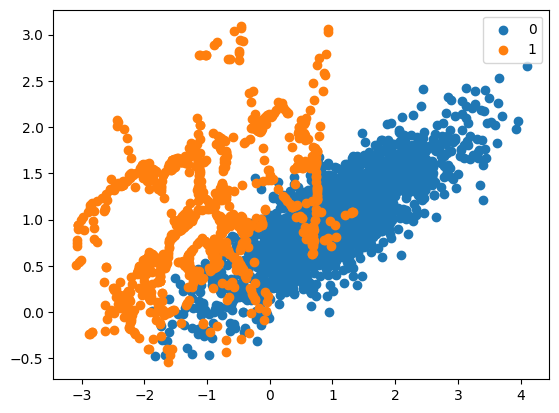

In [6]:
from imblearn.pipeline import Pipeline

steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps = steps)

# Transform the dataset
X, y = pipeline.fit_resample(X, y)

# Summarize the new class distribution
counter = Counter(y)
print(counter)

# Visualization the new class distribution
for label, _ in counter.items():
    row_ix = where(y == label)[0]
    plt.scatter(X[row_ix, 0], X[row_ix, 1], label = str(label))
plt.legend()
plt.show()

### SMOTE for Classification 

Review the results of model performance depending on imbalanced and data balanced using various SMOTE algorithms. 

In [7]:
from numpy import mean
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.tree import DecisionTreeClassifier

# Initial define dataset
X, y = make_classification(n_samples = 10_000, n_features = 2, n_redundant = 0, 
                           n_clusters_per_class = 1, weights = [0.99], flip_y = 0, random_state = 1)
# Initial model run with cross-validation
model = DecisionTreeClassifier()

# Evaluate pipeline (3 repeats of 10-fold cross-validation)
cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3, random_state = 1)
scores = cross_val_score(model, X, y, scoring = 'roc_auc', cv = cv, n_jobs = -1)

print('Mean ROC AUC: {:.3f}'.format(mean(scores)))

Mean ROC AUC: 0.771


In [8]:
# Same model, same evaluation method, but SMOTE transformed dataset

# Define pipeline with SMOTE parameters
steps = [('over', SMOTE()), ('model', DecisionTreeClassifier())]
pipeline = Pipeline(steps = steps)

# Evaluate pipeline (3 repeats of 10-fold cross-validation)
cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3, random_state = 1)
scores = cross_val_score(pipeline, X, y, scoring = 'roc_auc', cv = cv, n_jobs = -1)
print('Mean ROC AUC: {:.3f}'.format(mean(scores)))

Mean ROC AUC: 0.818


In [9]:
# Same model, same evaluation method, but SMOTE combined with undersampling of the majority class.

# Define pipeline with RandomUnderSampler parameters
steps = [('over', SMOTE(sampling_strategy = 0.1)),
         ('under', RandomUnderSampler(sampling_strategy = 0.5)),
         ('model', DecisionTreeClassifier())]
pipeline = Pipeline(steps = steps)

# Evaluate pipeline (3 repeats of 10-fold cross-validation)
cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3, random_state = 1)
scores = cross_val_score(pipeline, X, y, scoring = 'roc_auc', cv = cv, n_jobs = -1)
print('Mean ROC AUC: {:.3f}'.format(mean(scores)))

Mean ROC AUC: 0.851


Another area to explore would be to test different values of the k-nearest neighbors selected in the SMOTE procedure when each new synthetic example is created. The default is **k = 5**, although larger or smaller values will influence the types of examples created, and in turn, may impact the performance of the model.

In [10]:
# Same model, same evaluation method, SMOTE & undersampling. AND k-values evaluation.

for k in range(1, 11, 1):
    steps = [('over', SMOTE(sampling_strategy = 0.1)),
             ('under', RandomUnderSampler(sampling_strategy = 0.5)),
             ('model', DecisionTreeClassifier())]
    pipeline = Pipeline(steps = steps)

    cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3, random_state = 1)
    scores = cross_val_score(pipeline, X, y, scoring = 'roc_auc', cv = cv, n_jobs = -1)
    score = mean(scores)
    print('> k = {}, Mean ROC AUC: {:.3f}'.format(k, score))

> k = 1, Mean ROC AUC: 0.853
> k = 2, Mean ROC AUC: 0.846
> k = 3, Mean ROC AUC: 0.845
> k = 4, Mean ROC AUC: 0.835
> k = 5, Mean ROC AUC: 0.848
> k = 6, Mean ROC AUC: 0.834
> k = 7, Mean ROC AUC: 0.839
> k = 8, Mean ROC AUC: 0.845
> k = 9, Mean ROC AUC: 0.847
> k = 10, Mean ROC AUC: 0.837


### Borderline-SMOTE
A popular extension to SMOTE involves selecting those instances of the minority class that are misclassified, such as with a k-nearest neighbor classification model.

Instead of generating new synthetic examples for the minority class blindly, we would expect the **Borderline-SMOTE method** to only create synthetic examples along the decision boundary between the two classes.

Counter({0: 9900, 1: 100})
Counter({0: 9900, 1: 9900})


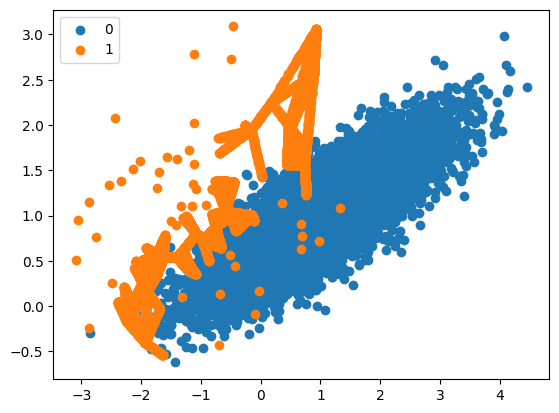

Mean ROC AUC: 0.991


In [11]:
from imblearn.over_sampling import BorderlineSMOTE

# Creating dataset
X, y = make_classification(n_samples = 10_000, n_features = 2, n_redundant = 0, 
                           n_clusters_per_class = 1, weights = [0.99], flip_y = 0, random_state = 1)

# Summarize class distribution
counter = Counter(y)
print(counter)

# Transform the dataset
oversample = BorderlineSMOTE()
X_bl, y_bl = oversample.fit_resample(X, y)

counter_bl = Counter(y_bl)
print(counter_bl)

# Visualization of examples by class label
for label, _ in counter_bl.items():
    row_ix = where(y_bl == label)[0]
    plt.scatter(X_bl[row_ix, 0], X_bl[row_ix, 1], label = str(label))
plt.legend()
plt.show()

# Model run with cross-validation
model = DecisionTreeClassifier()

# Evaluate pipeline (3 repeats of 10-fold cross-validation)
cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3, random_state = 1)
scores = cross_val_score(model, X_bl, y_bl, scoring = 'roc_auc', cv = cv, n_jobs = -1)

print('Mean ROC AUC: {:.3f}'.format(mean(scores)))

### Borderline-SMOTE SVM

It was suggested using an alternative of Borderline-SMOTE where an SVM algorithm is used instead of a KNN to identify misclassified examples on the decision boundary.

In addition to using an SVM, the technique attempts to select regions where there are fewer examples of the minority class and tries to extrapolate towards the class boundary.

This variation can be implemented via the **SVMSMOTE class** from the imbalanced-learn library.

Counter({0: 9900, 1: 100})
Counter({0: 9900, 1: 9900})


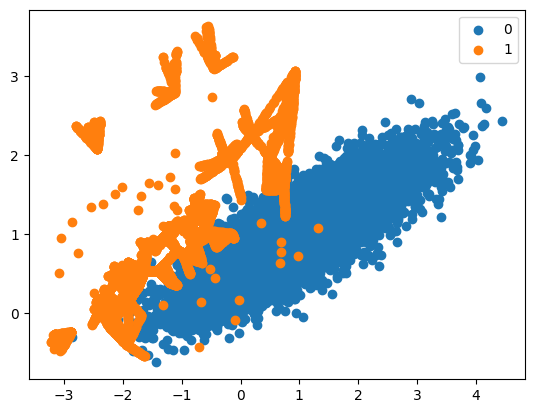

Mean ROC AUC: 0.992


In [12]:
from imblearn.over_sampling import SVMSMOTE

# Creating dataset
X, y = make_classification(n_samples = 10_000, n_features = 2, n_redundant = 0, 
                           n_clusters_per_class = 1, weights = [0.99], flip_y = 0, random_state = 1)

# Summarize class distribution
counter = Counter(y)
print(counter)

# Transform the dataset
oversample = SVMSMOTE()
X_sv, y_sv = oversample.fit_resample(X, y)

counter_sv = Counter(y_sv)
print(counter_sv)

# Visualization of examples by class label
for label, _ in counter_sv.items():
    row_ix = where(y_sv == label)[0]
    plt.scatter(X_sv[row_ix, 0], X_sv[row_ix, 1], label = str(label))
plt.legend()
plt.show()

# Model run with cross-validation
model = DecisionTreeClassifier()

# Evaluate pipeline (3 repeats of 10-fold cross-validation)
cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3, random_state = 1)
scores = cross_val_score(model, X_sv, y_sv, scoring = 'roc_auc', cv = cv, n_jobs = -1)

print('Mean ROC AUC: {:.3f}'.format(mean(scores)))

### Adaptive Synthetic Sampling (ADASYN)

Another approach involves generating synthetic samples inversely proportional to the density of the examples in the minority class.

That is, generate more synthetic examples in regions of the feature space where the density of minority examples is low, and fewer or none where the density is high.

We can implement this procedure using the **ADASYN** class in the imbalanced-learn library.

Counter({0: 9900, 1: 100})
Counter({0: 9900, 1: 9899})


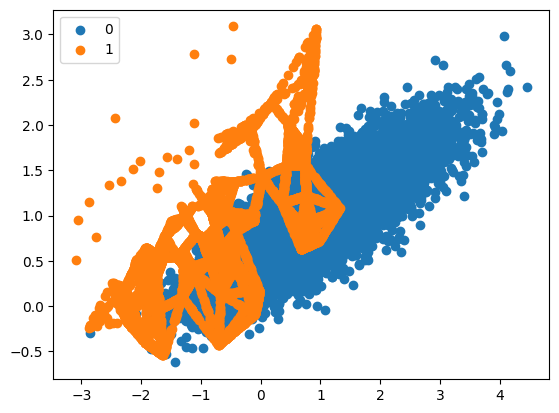

Mean ROC AUC: 0.926


In [13]:
from imblearn.over_sampling import ADASYN

# Creating dataset
X, y = make_classification(n_samples = 10_000, n_features = 2, n_redundant = 0, 
                           n_clusters_per_class = 1, weights = [0.99], flip_y = 0, random_state = 1)

# Summarize class distribution
counter = Counter(y)
print(counter)

# Transform the dataset
oversample = ADASYN()
X_ad, y_ad = oversample.fit_resample(X, y)

counter_ad = Counter(y_ad)
print(counter_ad)

# Visualization of examples by class label
for label, _ in counter_ad.items():
    row_ix = where(y_ad == label)[0]
    plt.scatter(X_ad[row_ix, 0], X_ad[row_ix, 1], label = str(label))
plt.legend()
plt.show()

# Model run with cross-validation
model = DecisionTreeClassifier()

# Evaluate pipeline (3 repeats of 10-fold cross-validation)
cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3, random_state = 1)
scores = cross_val_score(model, X_ad, y_ad, scoring = 'roc_auc', cv = cv, n_jobs = -1)

print('Mean ROC AUC: {:.3f}'.format(mean(scores)))

## Conclusion

When a machine learning model is trained on an imbalanced dataset it tends to perform poorly. When acquiring more data isn’t an option, we have to resort to down-sampling or up-sampling. Down-sampling is bad because it removes samples that could otherwise have been used to train the model. Up-sampling on its own is less than ideal since it causes our model to overfit. SMOTE is a technique to up-sample the minority classes while avoiding overfitting. It does this by generating new synthetic examples close to the other points (belonging to the minority class) in feature space.

https://medium.com/@corymaklin/synthetic-minority-over-sampling-technique-smote-7d419696b88c
https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/

## <center> Example of SMOTE for Balancing Data </center>
### <center> Using the Credit Card Fraud Detection Dataset </center>
### <center> to train a model to determine whether a given transaction is fraudulent </center>

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import Counter
from numpy import where
from numpy import mean

from sklearn.neighbors import NearestNeighbors
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.over_sampling import SVMSMOTE
from imblearn.over_sampling import ADASYN

In [15]:
card = pd.read_csv('creditcardfraud.zip')
card.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [16]:
# Checking the missing value, if any
card.isna().sum().sum()

0

In [17]:
# Remove time dimension for simplicity;
# Due to confidentiality the original features cannot be provided
# Features V1, V2, etc are the principal components obtained with PCA

X = card.drop(['Class', 'Time'], axis = 1)
y = card['Class']
X.shape, y.shape

((284807, 29), (284807,))

Counter({0: 284315, 1: 492})


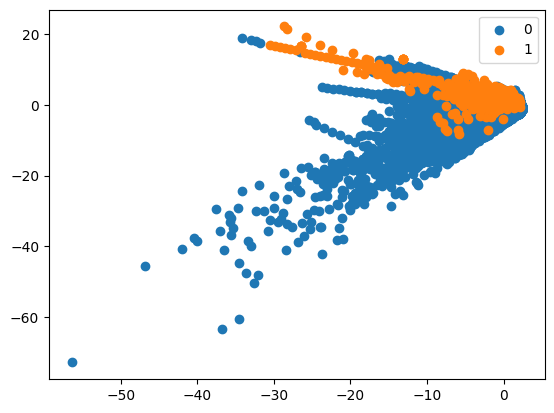

Mean Recall Score: 0.785


In [18]:
## Baseline

# Summarize class distribution
counter = Counter(y)
print(counter)

# Visualization by class labels
def visual(X, y):
    for label, _ in counter.items():
        row_ix = where(y == label)[0]
        plt.scatter(X.iloc[row_ix, 0], X.iloc[row_ix, 1], label = str(label))
    plt.legend()
    plt.show()

visual(X, y)
# Model with cross validation
model = RandomForestClassifier(random_state = 42)
cv = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 1, random_state = 42)
scores = cross_val_score(model, X, y, scoring = 'recall', cv = cv, n_jobs = -1)
print('Mean Recall Score: {:.3f}'.format(mean(scores)))

Counter({0: 284315, 1: 284315})


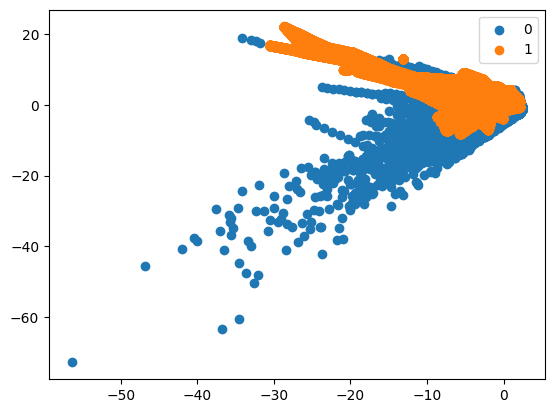

Mean Recall Score: 0.831


In [19]:
## Model with SMOTE default parameters

smote = SMOTE()
X_sm, y_sm = smote.fit_resample(X, y)

# Summarize new distribution of classes
counter = Counter(y_sm)
print(counter)

#Visualization by class label
visual(X_sm, y_sm)

## Model with cross validation
# Define pipeline with SMOTE parameters
steps = [('smote', SMOTE()), ('model', RandomForestClassifier(random_state = 42))]
pipeline = Pipeline(steps = steps)

cv = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 1, random_state = 42)
scores = cross_val_score(pipeline, X, y, scoring = 'recall', cv = cv, n_jobs = -1)
print('Mean Recall Score: {:.3f}'.format(mean(scores)))

Counter({0: 56862, 1: 28431})


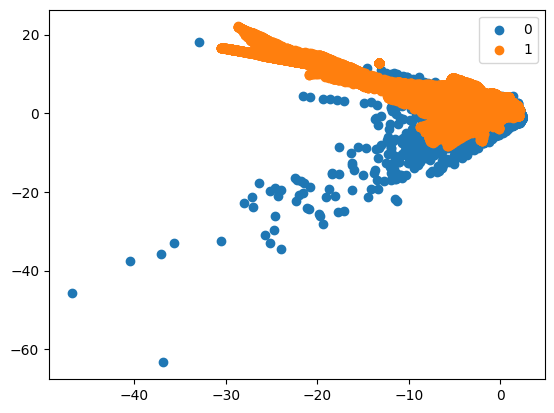

Mean Recall Score: 0.858


In [20]:
## Model with SMOTE combined with undersampling of the majority class.

over = SMOTE(sampling_strategy = 0.1)
under = RandomUnderSampler(sampling_strategy = 0.5)
step_one = [('o', over), ('u', under)]
pipeline_one = Pipeline(steps = step_one)

# Transform the dataset
X_rus, y_rus = pipeline_one.fit_resample(X, y)

# Summarize new distribution of classes
counter = Counter(y_rus)
print(counter)

# Visualization by class label
visual(X_rus, y_rus)

## Model with cross validation
# Define pipeline with SMOTE combined with undersampling of the majority class.
steps = [('over', SMOTE(sampling_strategy = 0.1)),
         ('under', RandomUnderSampler(sampling_strategy = 0.5)),
         ('model', RandomForestClassifier(random_state = 42))]
pipeline = Pipeline(steps = steps)

cv = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 1, random_state = 42)
scores = cross_val_score(pipeline, X, y, scoring = 'recall', cv = cv, n_jobs = -1)
print('Mean Recall Score: {:.3f}'.format(mean(scores)))

Counter({0: 284315, 1: 284315})


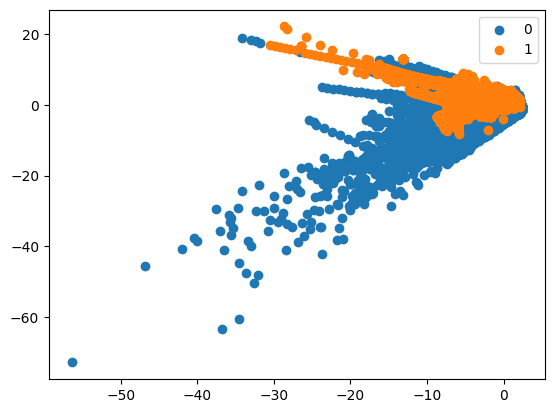

Mean Recall Score: 1.000


In [21]:
# Model with Borderline - SMOTE

## Transform the dataset
oversample = BorderlineSMOTE()
X_bl, y_bl = oversample.fit_resample(X, y)

counter = Counter(y_bl)
print(counter)

visual(X_bl, y_bl)

## Model run with cross validation
model = RandomForestClassifier(random_state = 42)
cv = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 1, random_state = 42)
scores = cross_val_score(model, X_bl, y_bl, scoring = 'recall', cv = cv, n_jobs = -1)
print('Mean Recall Score: {:.3f}'.format(mean(scores)))

Counter({0: 284315, 1: 284315})


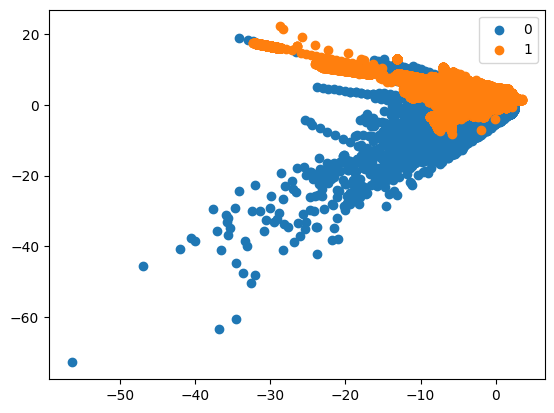

Mean Recall Score: 1.000


In [22]:
# Model with Borderline = SMOTE SVM

## Transform the dataset
oversample = SVMSMOTE()
X_sv, y_sv = oversample.fit_resample(X, y)

counter = Counter(y_sv)
print(counter)

visual(X_sv, y_sv)

## Model run with cross validation
model = RandomForestClassifier(random_state = 42)
cv = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 1, random_state = 42)
scores = cross_val_score(model, X_sv, y_sv, scoring = 'recall', cv = cv, n_jobs = -1)
print('Mean Recall Score: {:.3f}'.format(mean(scores)))

Counter({0: 284315, 1: 284240})


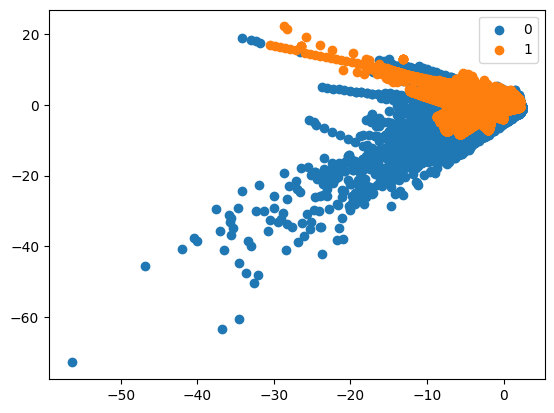

Mean Recall Score: 1.000


In [23]:
# Model with ADASYN

## Transform the dataset
oversample = ADASYN()
X_ad, y_ad = oversample.fit_resample(X, y)

counter = Counter(y_ad)
print(counter)

visual(X_ad, y_ad)

## Model run with cross-validation
model = RandomForestClassifier(random_state = 42)
cv = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 1, random_state = 42)
scores = cross_val_score(model, X_ad, y_ad, scoring = 'recall', cv = cv, n_jobs = -1)
print('Mean Recall Score: {:.3f}'.format(mean(scores)))

## Conclusion

The best results were achieved using the SMOTE combined with the undersampling of majority class